In [1]:
### Hayden Gallo
### Bucci Lab
### 9/5/24

### simple one model species combined gLV and dfba model


### utilizing cobraPY and dfba

import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

### importing truncated normal from scipy to then randomly sample from posterior distribution of MCMC fit of gLV, then using these samples to run dFBA x number of times using inferred parameters

from scipy.stats import truncnorm



In [2]:
### loading cobra models

### for some reason, sbml/xml models give different initial growth rates than same model but in .mat format???? why 

p_copri_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panPrevotella_copri.mat')  
#p_copri_model = cobra.io.read_sbml_model('/Users/haydengallo/Documents/Bucci_Lab/metconsin/AMANHI_P_xml_models/panPrevotella_copri.xml')
#f_prau_model = cobra.io.read_sbml_model('/Users/haydengallo/Documents/Bucci_Lab/metconsin/AMANHI_P_xml_models/panFaecalibacterium_prausnitzii.xml')
eb_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panEubacterium_limosum.mat') 
#do_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panDorea_longicatena.mat')
#do_model = cobra.io.load_matlab_model('/Users/haydengallo/Documents/Bucci_Lab/panDorea_longicatena.mat')
#fp_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panFaecalibacterium_prausnitzii.mat') 

#fp_strain_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/AGORA-2/AGORA_2_mat/Faecalibacterium_prausnitzii_ERR1022327.mat')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [3]:
do_model = cobra.io.load_matlab_model('/Users/haydengallo/cobratoolbox/panSpeciesModels/panDorea_longicatena.mat')

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [4]:
### Need to determine some new objective rather than optimizing for maximial biomass, all i want is to constrain biomass 

In [6]:
### loading initial metabolite data

#agora_media = pd.read_csv('/Users/haydengallo/Documents/Bucci_Lab/metconsin/AGORA_Media/EU_average_AGORA.tsv', sep = '\t', index_col=0)

### with additions for EB to grow

pyg_test_all_add = [['EX_26dap_M(e)','1'],['EX_2dmmq8(e)','1'],['EX_cgly(e)','1'],['EX_mqn8(e)','1'],['EX_o2(e)','1'],['EX_orn(e)','1'],['EX_sheme(e)','1'],['EX_spmd(e)','1'],['EX_q8(e)','1'],['EX_pydx(e)','1'],['EX_nac(e)','1'],['EX_lys_L(e)','1'],['EX_hxan(e)','1'],['EX_ade(e)','1'],['EX_thymd(e)','1'],['EX_thm(e)','1'],['EX_ribflv(e)','1'],['EX_pnto_R(e)','1'],['EX_nac(e)','1'],['EX_fol(e)','1'],['EX_zn2(e)','1'],['EX_mn2(e)','1'],['EX_fe3(e)','1'],['EX_cu2(e)','1'],['EX_cobalt2(e)','1'],['EX_n2(e)','227.8571429'],['EX_na1(e)','20.51163798'],['EX_cl(e)','5.941065976'],['EX_ca2(e)','0.173941043'],['EX_fe2(e)','0.016053362'],['EX_mg2(e)','0.474477191'],['EX_k(e)','35.39748582'],['EX_so4(e)','0.710983412'],['EX_pi(e)','18.29826648'],['EX_ala_L(e)','16.89227108'],['EX_arg_L(e)','5.338568575'],['EX_asn_L(e)','1.286718791'],['EX_asp_L(e)','10.81893313'],['EX_Lcystin(e)','0.187272152'],['EX_glu_L(e)','18.56754922'],['EX_gln_L(e)','0.205274178'],['EX_gly(e)','20.3151851'],['EX_his_L(e)','3.319218598'],['EX_ile_L(e)','8.195159139'],['EX_leu_L(e)','11.2826377'],['EX_lys_l(e)','9.884397018'],['EX_met_L(e)','2.144657123'],['EX_phe_L(e)','6.083829725'],['EX_pro_L(e)','11.89938505'],['EX_ser_L(e)','4.424652451'],['EX_thr_L(e)','3.567830759'],['EX_trp_L(e)','0.685504997'],['EX_tyr_L(e)','1.683306566'],['EX_val_L(e)','10.37149589'],['EX_glc_D(e)','27.7537245498346'],['EX_hco3(e)','1.190379826'],['EX_phyQ(e)','0.002172408'],['EX_etoh(e)','3.237913066'],['EX_pheme(e)','0.0076693'],['EX_oh1(e)','0.099987502'],['EX_cys_L(e)','2.846894039'],['EX_M02144(e)','2.846894039'],['EX_h2o(e)','55013.2623'],['EX_h(e)','6.30957E-05']]
#pyg_test_all_add = [['EX_26dap_M[e]','1'],['EX_2dmmq8[e]','1'],['EX_cgly[e]','1'],['EX_mqn8[e]','1'],['EX_o2[e]','1'],['EX_orn[e]','1'],['EX_sheme[e]','1'],['EX_spmd[e]','1'],['EX_q8[e]','1'],['EX_pydx[e]','1'],['EX_nac[e]','1'],['EX_lys_L[e]','1'],['EX_hxan[e]','1'],['EX_ade[e]','1'],['EX_thymd[e]','1'],['EX_thm[e]','1'],['EX_ribflv[e]','1'],['EX_pnto_R[e]','1'],['EX_nac[e]','1'],['EX_fol[e]','1'],['EX_zn2[e]','1'],['EX_mn2[e]','1'],['EX_fe3[e]','1'],['EX_cu2[e]','1'],['EX_cobalt2[e]','1'],['EX_n2[e]','227.8571429'],['EX_na1[e]','20.51163798'],['EX_cl[e]','5.941065976'],['EX_ca2[e]','0.173941043'],['EX_fe2[e]','0.016053362'],['EX_mg2[e]','0.474477191'],['EX_k[e]','35.39748582'],['EX_so4[e]','0.710983412'],['EX_pi[e]','18.29826648'],['EX_ala_L[e]','16.89227108'],['EX_arg_L[e]','5.338568575'],['EX_asn_L[e]','1.286718791'],['EX_asp_L[e]','10.81893313'],['EX_Lcystin[e]','0.187272152'],['EX_glu_L[e]','18.56754922'],['EX_gln_L[e]','0.205274178'],['EX_gly[e]','20.3151851'],['EX_his_L[e]','3.319218598'],['EX_ile_L[e]','8.195159139'],['EX_leu_L[e]','11.2826377'],['EX_lys_l[e]','9.884397018'],['EX_met_L[e]','2.144657123'],['EX_phe_L[e]','6.083829725'],['EX_pro_L[e]','11.89938505'],['EX_ser_L[e]','4.424652451'],['EX_thr_L[e]','3.567830759'],['EX_trp_L[e]','0.685504997'],['EX_tyr_L[e]','1.683306566'],['EX_val_L[e]','10.37149589'],['EX_glc_D[e]','27.7537245498346'],['EX_hco3[e]','1.190379826'],['EX_phyQ[e]','0.002172408'],['EX_etoh[e]','3.237913066'],['EX_pheme[e]','0.0076693'],['EX_oh1[e]','0.099987502'],['EX_cys_L[e]','2.846894039'],['EX_M02144[e]','2.846894039'],['EX_h2o[e]','55013.2623'],['EX_h[e]','6.30957E-05']]
#pyg_test_all_add = [['EX_q8[e]','1'],['EX_pydx[e]','1'],['EX_nac[e]','1'],['EX_lys_L[e]','1'],['EX_hxan[e]','1'],['EX_ade[e]','1'],['EX_thymd[e]','1'],['EX_thm[e]','1'],['EX_ribflv[e]','1'],['EX_pnto_R[e]','1'],['EX_nac[e]','1'],['EX_fol[e]','1'],['EX_zn2[e]','1'],['EX_mn2[e]','1'],['EX_fe3[e]','1'],['EX_cu2[e]','1'],['EX_cobalt2[e]','1'],['EX_n2[e]','227.8571429'],['EX_na1[e]','20.51163798'],['EX_cl[e]','5.941065976'],['EX_ca2[e]','0.173941043'],['EX_fe2[e]','0.016053362'],['EX_mg2[e]','0.474477191'],['EX_k[e]','35.39748582'],['EX_so4[e]','0.710983412'],['EX_pi[e]','18.29826648'],['EX_ala_L[e]','16.89227108'],['EX_arg_L[e]','5.338568575'],['EX_asn_L[e]','1.286718791'],['EX_asp_L[e]','10.81893313'],['EX_Lcystin[e]','0.187272152'],['EX_glu_L[e]','18.56754922'],['EX_gln_L[e]','0.205274178'],['EX_gly[e]','20.3151851'],['EX_his_L[e]','3.319218598'],['EX_ile_L[e]','8.195159139'],['EX_leu_L[e]','11.2826377'],['EX_lys_l[e]','9.884397018'],['EX_met_L[e]','2.144657123'],['EX_phe_L[e]','6.083829725'],['EX_pro_L[e]','11.89938505'],['EX_ser_L[e]','4.424652451'],['EX_thr_L[e]','3.567830759'],['EX_trp_L[e]','0.685504997'],['EX_tyr_L[e]','1.683306566'],['EX_val_L[e]','10.37149589'],['EX_glc_D[e]','27.7537245498346'],['EX_hco3[e]','1.190379826'],['EX_phyQ[e]','0.002172408'],['EX_etoh[e]','3.237913066'],['EX_pheme[e]','0.0076693'],['EX_oh1[e]','0.099987502'],['EX_cys_L[e]','2.846894039'],['EX_M02144[e]','2.846894039'],['EX_h2o[e]','55013.2623'],['EX_h[e]','6.30957E-05']]
pyg_test_all_add = np.array(pyg_test_all_add)

pyg_test_all_add = pd.DataFrame(pyg_test_all_add)

pyg_test_all_add.columns = ['reaction','fluxValue']
pyg_test_all_add['fluxValue'] =  np.double(pyg_test_all_add['fluxValue'])


rcm_add = [['EX_ribflv(e)', '0.01'],['EX_thymd(e)', '0.01'],['EX_thm(e)', '0.01'],['EX_spmd(e)', '0.01'],['EX_sheme(e)', '0.01'],['EX_q8(e)', '0.01'],['EX_pheme(e)', '0.01'],['EX_fol(e)', '0.01'],['EX_2dmmq8(e)', '0.01'],['EX_26dap_M(e)', '0.01'],['EX_cobalt2(e)', '0.01'],['EX_cu2(e)', '0.01'],['EX_fe3(e)', '0.01'],['EX_mn2(e)', '0.01'],['EX_zn2(e)', '0.01'],['EX_na1(e)', '49.13878039'],['EX_cl(e)', '35.42367951'],['EX_n2(e)', '221.9285714'],['EX_ca2(e)', '0.083087978'],['EX_fe2(e)', '0.009273883'],['EX_mg2(e)', '0.216827813'],['EX_k(e)', '10.45186108'],['EX_so4(e)', '0.913009078'],['EX_pi(e)', '4.844687796'],['EX_ala_L(e)', '16.70146138'],['EX_arg_L(e)', '5.384491745'],['EX_asn_L(e)', '0.908272088'],['EX_asp_L(e)', '9.083395943'],['EX_glu_L(e)', '17.32518669'],['EX_gly(e)', '25.44393675'],['EX_his_L(e)', '2.120432852'],['EX_ile_L(e)', '6.174957118'],['EX_leu_L(e)', '9.323422908'],['EX_lys_L(e)', '7.168752993'],['EX_met_L(e)', '1.702321591'],['EX_phe_L(e)', '5.193956124'],['EX_pro_L(e)', '11.3782441'],['EX_ser_L(e)', '3.882275699'],['EX_thr_L(e)', '2.837474815'],['EX_trp_L(e)', '0.56309339'],['EX_tyr_L(e)', '1.357683329'],['EX_val_L(e)', '7.89599481'], ['EX_Lcystin(e)', '0.108201688'], ['EX_gln_L(e)', '0.109479562'],['EX_glc_D(e)', '27.75372455'],['EX_cys_L(e)', '2.846894039'],['EX_M02144(e)', '2.846894039'],['EX_h2o(e)', '55509.29781'],['EX_h(e)', '0.000158489']]
rcm_add = np.array(rcm_add)


rcm_add = [['EX_h2s(e)','0.01'],['EX_ribflv(e)', '0.01'],['EX_thymd(e)', '0.01'],['EX_thm(e)', '0.01'],['EX_spmd(e)', '0.01'],['EX_sheme(e)', '0.01'],['EX_q8(e)', '0.01'],['EX_pheme(e)', '0.01'],['EX_fol(e)', '0.01'],['EX_2dmmq8(e)', '0.01'],['EX_26dap_M(e)', '0.01'],['EX_cobalt2(e)', '0.01'],['EX_cu2(e)', '0.01'],['EX_fe3(e)', '0.01'],['EX_mn2(e)', '0.01'],['EX_zn2(e)', '0.01'],['EX_na1(e)', '49.13878039'],['EX_cl(e)', '35.42367951'],['EX_n2(e)', '221.9285714'],['EX_ca2(e)', '0.083087978'],['EX_fe2(e)', '0.009273883'],['EX_mg2(e)', '0.216827813'],['EX_k(e)', '10.45186108'],['EX_so4(e)', '0.913009078'],['EX_pi(e)', '4.844687796'],['EX_ala_L(e)', '16.70146138'],['EX_arg_L(e)', '5.384491745'],['EX_asn_L(e)', '0.908272088'],['EX_asp_L(e)', '9.083395943'],['EX_glu_L(e)', '17.32518669'],['EX_gly(e)', '25.44393675'],['EX_his_L(e)', '2.120432852'],['EX_ile_L(e)', '6.174957118'],['EX_leu_L(e)', '9.323422908'],['EX_lys_L(e)', '7.168752993'],['EX_met_L(e)', '1.702321591'],['EX_phe_L(e)', '5.193956124'],['EX_pro_L(e)', '11.3782441'],['EX_ser_L(e)', '3.882275699'],['EX_thr_L(e)', '2.837474815'],['EX_trp_L(e)', '0.56309339'],['EX_tyr_L(e)', '1.357683329'],['EX_val_L(e)', '7.89599481'], ['EX_Lcystin(e)', '0.108201688'], ['EX_gln_L(e)', '0.109479562'],['EX_glc_D(e)', '27.75372455'],['EX_cys_L(e)', '2.846894039'],['EX_M02144(e)', '2.846894039'],['EX_h2o(e)', '55509.29781'],['EX_h(e)', '0.000158489']]
rcm_add = pd.DataFrame(rcm_add)

rcm_add.columns = ['reaction','fluxValue']
rcm_add['fluxValue'] =  np.double(rcm_add['fluxValue'])



pyg_test_all_add.shape

(64, 2)

In [7]:
pyg_media_dict = dict(zip(pyg_test_all_add['reaction'], pyg_test_all_add['fluxValue']))
rcm_media_dict = dict(zip(rcm_add['reaction'], rcm_add['fluxValue']))
#rcm_media_dict

In [8]:
#init_media = agora_media[['reaction','fluxValue']]

### initializing with correct models and abundances



#model_abun_dict = init_model_abun(model_names=model_names,models = models, init_abun=init_abun, glv_out=x_y)


In [9]:
### implementing function to create dict for initial microbial abundance paired with model
### becomes important later for loading models from just list of model names etc. 

### make dict of dicts to keep track of model names, models, and abundances of species

def init_model_abun(model_names, models, init_abun, glv_out):
    
    model_abun_dict = {}

    for i in range(0, len(model_names)):

        model_abun_dict[model_names[i]] = {}
        model_abun_dict[model_names[i]]['model'] = models[i]
        model_abun_dict[model_names[i]]['abun'] = init_abun[i]
        ### Need to figure out a better key system for incorporating glv out 
        model_abun_dict[model_names[i]]['glv_out'] = glv_out[:,i]
        model_abun_dict[model_names[i]]['fba_biomass'] = [init_abun[i]]
        model_abun_dict[model_names[i]]['flux_up'] = []
        model_abun_dict[model_names[i]]['flux_sec'] = []

    return model_abun_dict



In [10]:
def make_media(model, media):

    media_dict = {}

    for i in range(0, len(media)):

        #media_dict[media['reaction'].iloc[i].replace('[','(').replace(']',')')] = media['fluxValue'].iloc[i]
        if media['reaction'].iloc[i].replace('[','(').replace(']',')') in model.medium.keys():

            media_dict[media['reaction'].iloc[i].replace('[','(').replace(']',')')] = media['fluxValue'].iloc[i]

        else:
            continue

    return media_dict

In [11]:
def change_media(model_abun_dict, supplied_media):

    for key in model_abun_dict:
        
        temp_media = make_media(model_abun_dict[key]['model'], media=supplied_media)

        # set media conditions to be the temp_media

        model_abun_dict[key]['model'].medium = temp_media

        ### here we take our temp media and apply to model.medium while also checking to make sure lengths are correct, if len(temp_media) != len(model.medium.keys) 
        ### then we determine which metabolites are missing and manually change them in model.reactions.get_by_id('reaction').lower_bound = -flux

        if len(temp_media) == len(model_abun_dict[key]['model'].medium.keys()):
            #print('good to go')
            continue

        else:

            if 'EX_ribflv(e)' in temp_media.keys():
                print('yes')
                model_abun_dict[key]['model'].get_by_id(id='EX_ribflv(e)').lower_bound = temp_media['EX_ribflv(e)']
                
            else:
                print('no')
    return

In [12]:
### this is to be run after optimization step 

def model_opt_out(model_abun_dict, delta_t, pfba):

    total_sys_uptake = {}
    total_sys_secretion = {}

    for key in model_abun_dict:

        if pfba == True:

            # optimize model i via pfba 
            temp_pfba = cobra.flux_analysis.pfba(model_abun_dict[key]['model'])
            # put fluxes in df for manipulation
            temp_pfba_df = temp_pfba.to_frame().filter(regex='EX_', axis = 0)
            
            # filter out fluxes that are secreted
            # signs are flipped here compared to standard fba optimization in cobapy so must change them

            # secreted should have negative sign to align with normal FBA
            test_secrete = temp_pfba_df[temp_pfba_df['fluxes'] > 0]
            # filter out fluxes that are taken up
            # uptake should have positive sign to align with normal FBA
            test_uptake = temp_pfba_df[temp_pfba_df['fluxes'] < 0]

            temp_uptake = np.abs(test_uptake['fluxes']) * delta_t * model_abun_dict[key]['abun']
            temp_secrete = -1.0*(test_secrete['fluxes']) * delta_t * model_abun_dict[key]['abun']   
            print(temp_secrete)
            if model_abun_dict[key]['model'].reactions.get_by_id(id = 'biomassPan').upper_bound < 1e-5:
                pfba_obj_val = 0
            else:
                pfba_obj_val = test_secrete.filter(regex='bio', axis=0)['fluxes'].iloc[0]

            print('Obj val', pfba_obj_val)
            model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + pfba_obj_val
        
        else:

            test_secrete = model_abun_dict[key]['model'].summary().secretion_flux.loc[model_abun_dict[key]['model'].summary().secretion_flux['reaction'].filter(regex='EX_')]
            test_uptake = model_abun_dict[key]['model'].summary().uptake_flux.loc[model_abun_dict[key]['model'].summary().uptake_flux['reaction'].filter(regex='EX_')]

            test_secrete = test_secrete[test_secrete['flux'] !=0 ]
            test_uptake = test_uptake[test_uptake['flux'] !=0 ]

            temp_uptake = test_uptake['flux'] * delta_t * model_abun_dict[key]['abun']
            temp_secrete = test_secrete['flux'] * delta_t * model_abun_dict[key]['abun']

            ### now that we've converted metabolite fluxes using abundance of previous time step, now update bacterial abundance for time t + 1

            #model_abun_dict[key]['abun'] += model_abun_dict[key]['model'].summary()._objective_value * model_abun_dict[key]['abun'] * delta_t

            #print(model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun'], 'add this amount')
            #print(model_abun_dict[key]['model'].summary()._objective_value, 'model obj')
            #print(model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun'], 'amount add')


            #model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun']
            model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + model_abun_dict[key]['model'].summary()._objective_value

            print('Obj val', model_abun_dict[key]['model'].summary()._objective_value)

        ### this is wrong for some reason... 
        
        model_abun_dict[key]['fba_biomass'].append(model_abun_dict[key]['abun'])
        #print(model_abun_dict[model_names[i]]['abun'])

        # dict of uptake for model x in i to n 
        uptake_dict = dict(zip(temp_uptake.index, temp_uptake))
        # add uptake_dict at time t to model storage
        model_abun_dict[key]['flux_up'].append(uptake_dict.copy())
        # dict of sec for model x in i to n 
        secrete_dict = dict(zip(temp_secrete.index, temp_secrete))
        # add sec_dict at time t to model storage
        model_abun_dict[key]['flux_sec'].append(secrete_dict.copy())

        for key in uptake_dict:
            if key in total_sys_uptake.keys():
                #print(uptake_dict[key])
                #print(met_pool_dict[key])
                total_sys_uptake[key] += uptake_dict[key]
                #print(total_sys_uptake[key])
            else:
                total_sys_uptake[key] = np.abs(uptake_dict[key])
            #else:
                ### if there's a key in uptake dict that isn't found in met_pool something is wrong, kill sim ###
            #    RuntimeError()

        for key in secrete_dict:
            if key in total_sys_secretion.keys():
                total_sys_secretion[key] += np.abs(secrete_dict[key])
            else:
                if key == 'EX_biomass(e)':
                    #print('biomass')
                    continue
                else:
                    ### here add new metabolite to metabolite pool 
                    total_sys_secretion[key] = np.abs(secrete_dict[key])
                    #print(np.abs(secrete_dict[key]))
            

    return total_sys_uptake, total_sys_secretion


In [13]:
def multi_spec_gLV(X, t, params):

    ### hmm need to expand this to account for N species, i guess for now I can just expand such that I account for 3 species 
    x, y, z = X 
    r_1, r_2, r_3, gamma_EP, gamma_ED, gamma_PE, gamma_PD, gamma_DE, gamma_DP, a_1, a_2, a_3 =  params

    # EB concentration integrated overtime
    dxdt = x * (r_1 + a_1*x + gamma_EP*y + gamma_ED*z)

    # P. copri concentration integrated overtime 
    dydt = y * (r_2 + a_2*y + gamma_PE*x + gamma_PD*z)

    # Dorea concentration integrated overtime 
    dzdt = z * (r_3 + a_3*z + gamma_DE*x + gamma_DP*y)


    return [dxdt, dydt, dzdt]

In [14]:
def change_biomass_bounds(model_abun_dict, glv_params, t_pt):

    temp_abun_list = []
    for key in model_abun_dict:
        temp_abun_list.append(model_abun_dict[key]['glv_out'][t_pt])
    
    gr_rt_t_pt = multi_spec_gLV(temp_abun_list, t_pt, params=glv_params)
    #print(gr_rt_t_pt)

    for count, key in enumerate(model_abun_dict):
        if gr_rt_t_pt[count] > 0:
            model_abun_dict[key]['model'].reactions.get_by_id(id = 'biomassPan').upper_bound = gr_rt_t_pt[count]

        else:
            model_abun_dict[key]['model'].reactions.get_by_id(id = 'biomassPan').upper_bound = 0

In [15]:
### shouldn't this be embedded in model_opt_out?
### maybe but i kinda want metabolite pool to stay untouched until end of time point 

def update_met_pool(uptake_dict, secrete_dict, met_pool_dict):

    for key in uptake_dict:
        if key in met_pool_dict.keys():
            #print(uptake_dict[key])
            #print(met_pool_dict[key])
            met_pool_dict[key] -= uptake_dict[key]
            #print(met_pool_dict[key])
        else:
            ### if there's a key in uptake dict that isn't found in met_pool something is wrong, kill sim ###
            RuntimeError()

    for key in secrete_dict:
        if key in met_pool_dict.keys():
            met_pool_dict[key] += secrete_dict[key]
        else:
            if key == 'EX_biomass(e)':
                #print('biomass')
                continue
            else:
                ### here add new metabolite to metabolite pool 
                met_pool_dict[key] = np.abs(secrete_dict[key])
                #print(np.abs(secrete_dict[key]))
                
    return met_pool_dict    

In [16]:
#t_step = 5/60

#temp_uptake = test_uptake['flux'] * t_step * model_abun_dict['p_copri']['abun']
#temp_secrete = test_secrete['flux'] * t_step * model_abun_dict['p_copri']['abun']

#dict_up = dict(zip(temp_uptake.index, temp_uptake))
#dict_sec = dict(zip(temp_secrete.index, temp_secrete))


In [17]:
### abundance dict, loop through, opt 
### might be a good idea to vectorize this step at some point ###

def opt_model(model_abun_dict, pfba):

    if pfba == True:
        return
    else:
        for key in model_abun_dict:
            model_abun_dict[key]['model'].optimize()

    return    

In [18]:
### implementing static opt dfba approach

### this is the main function that wraps all other helper functions ### 

def static_dfba(list_model_names, list_models, initial_abundance, total_sim_time, num_t_steps, microbe_data, glv_params_init, environ_cond, pfba, glv_out):

    # implementing a static optimization approach dfba
    # this is a basic approach and will potentially implement more efficient approach later on 

    # to start must run an initial fba at initial conditions to obtain original growth rate etc. 

    # t: time 
    # x: is our steady state concentrations of biomass for both microbes and metabolites

    # we can integrate ODE from time t to t+1 and stop integration there, then we will take new variables and adjust concentrations of 
    # metabolites and microbes at time t+1 to then rerun fba again for each microbe 
    # I can make separate 

    # dxdt : taxa conc
    # dydt : metabolite concentration

    #dxdt = init_conc * growth_rate
    #dydt = init_conc*np.dot(init_conc*flux)

    # i think that the interaction coefficients should tell us something about if these bacteria will compete for the same resources or take from resources secreted by the other 


    ### Maybe start by transforming differential equations into linear approach b/c SOA method can be easily transformed 

    # steps of static dfba coupled with gLV

    # 1. fit gLV to time series data 
    # 2. obtain initial conditions of bacterial concentration and media conditions 
    # 3. discretize the time series into x = n timesteps
    # 4. estimate slope/rate from t=0 to t=1 for abundance of every taxa present in simulation
    # 5. simulate fba with up and lb constrained by species specific growth rate defined by gLV
    # 6. based on fluxes need, both secretory and uptake need to update pool of metabolites in environment before next time step
    # 7. repeat steps 4-6 until end of time series or we get infeasible FBA solution 
    # 8. once at end of time series, then report final metabolite concentrations etc. but use previous timesteps value (t-1) to update fluxes i.e. [x t-1]*flux

    
    # here i need to set the media conditions for each model 
    # really need to build genomic scale models and then gap fill based on media conditions 

    ### Come up with roadmap/diagram of ideas for Vanni 

    ## need to grab derivative at every time point, can i just do that by inserting concentration at time t?? need to do a bit of reading on this      

    ### here is where we perform initial least squares fit of glv to data
    
    #glv_out, params_ls = ls_glv_fit(init_abun = initial_abundance, params = glv_params_init, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=microbe_data)
    params_ls = glv_params_init
    #print(glv_out)
    ### Make initial metabolite pool dict
    # this is our initial metabolite pool

    # initialize list to hold dictionaries of metabolite pool over time
    met_pool_over_time = []

    met_pool_dict = dict(zip(environ_cond['reaction'], environ_cond['fluxValue']))

    ## add initial conditions to the list of dicts of metabolite pool

    met_pool_over_time.append(met_pool_dict.copy())

    # Step 0. Create model_abun_dict, main dictionary for everything

    model_abun_dict = init_model_abun(model_names=list_model_names,models = list_models, init_abun=initial_abundance, glv_out=glv_out)
    
    for i in range(0, num_t_steps):
        print('Time step: ', i)

        # Step 1. Change media conditions of models 

        change_media(model_abun_dict= model_abun_dict, supplied_media= environ_cond)

        # Step 2. Change upper bounds of biomass growth rate for each model

        change_biomass_bounds(model_abun_dict=model_abun_dict, glv_params=params_ls, t_pt=i)

        # Step 3. Run actual FBA/optimization

        opt_model(model_abun_dict=model_abun_dict, pfba=pfba)

        # Step 4. Adjust model optimization output fluxes based on abundance and time step size

        total_sys_uptake, total_sys_secretion = model_opt_out(model_abun_dict=model_abun_dict, delta_t= (total_sim_time/num_t_steps), pfba=pfba)

        # Step 5. Update total metabolite pool
        met_pool_dict  = update_met_pool(uptake_dict=total_sys_uptake, secrete_dict=total_sys_secretion, met_pool_dict=met_pool_dict)
        #print(met_pool_dict)
        met_pool_over_time.append(met_pool_dict.copy())
        #print(len(met_pool_over_time))


    ### add function here that transforms the list of dicts of the metabolite pool into a dataframe
    ## Quick plot for confirmation
    
    time = np.arange(0, 461, 1)
    #params = results.x
    #x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))
    x = glv_out[:,0]; y = glv_out[:,1]
    '''
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, x, label = 'EB(LS model)')
    ax.plot(time, y, label = 'PC (LS model)')
    ax.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)')
    ax.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)')
    ax.plot(time, model_abun_dict['eb']['fba_biomass'], label = 'EB (FBA)')
    ax.plot(time, model_abun_dict['p_copri']['fba_biomass'], label = 'PC (FBA)')


    #ax.plot(time, x_naive, color = 'red' , label = 'naive_F_prau')
    #ax.plot(time, y_naive, color = 'black', label = 'naive_P_copri')



    plt.legend()
    plt.show()

    '''



    
    return met_pool_over_time, model_abun_dict, params_ls





In [19]:
'''
    ### add function here that transforms the list of dicts of the metabolite pool into a dataframe
    ## Quick plot for confirmation
    time = np.arange(0, 461, 1)
    #params = results.x
    #x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))
    x = glv_out[:,0]; y = glv_out[:,1]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, x, label = 'EB(LS model)')
    ax.plot(time, y, label = 'PC (LS model)')
    ax.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)')
    ax.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)')
    ax.plot(time, model_abun_dict['eb']['fba_biomass'], label = 'EB (FBA)')
    ax.plot(time, model_abun_dict['p_copri']['fba_biomass'], label = 'PC (FBA)')


    #ax.plot(time, x_naive, color = 'red' , label = 'naive_F_prau')
    #ax.plot(time, y_naive, color = 'black', label = 'naive_P_copri')



    plt.legend()
    plt.show()

'''

"\n    ### add function here that transforms the list of dicts of the metabolite pool into a dataframe\n    ## Quick plot for confirmation\n    time = np.arange(0, 461, 1)\n    #params = results.x\n    #x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))\n    x = glv_out[:,0]; y = glv_out[:,1]\n\n    fig, ax = plt.subplots(figsize=(12, 4))\n    ax.plot(time, x, label = 'EB(LS model)')\n    ax.plot(time, y, label = 'PC (LS model)')\n    ax.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)')\n    ax.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)')\n    ax.plot(time, model_abun_dict['eb']['fba_biomass'], label = 'EB (FBA)')\n    ax.plot(time, model_abun_dict['p_copri']['fba_biomass'], label = 'PC (FBA)')\n\n\n    #ax.plot(time, x_naive, color = 'red' , label = 'naive_F_prau')\n    #ax.plot(time, y_naive, color = 'black', label = 'naive_P_copri')\n\n\n\n    plt.legend()\n    plt.show()\n\

In [20]:
# function that calculates residuals based on a given theta
def ode_model_resid(params):
    return (
        microbe_data.iloc[:,1:] - odeint(generalized_gLV, y0 = init_abun, t=microbe_data['Time'], args = (params,))
    ).values.flatten()

In [21]:
### implementing naive gLV

def generalized_gLV(X, t, params):
    x, y = X 
    r_1, r_2, gamma_1, gamma_2, a_1, a_2 =  params

    # EB concentration integrated overtime
    dxdt = x * (r_1 + a_1*x + gamma_1*y)
    
    # P.copri concentration integrated overtime
    dydt = y * (r_2 + gamma_2*x + a_2*y)

    return [dxdt, dydt]


In [22]:
def ls_glv_fit(init_abun, params, total_sim_time, time_steps, microbe_data):

    init_abun = np.array(init_abun)
    
    results = least_squares(ode_model_resid, x0=params, bounds=([0, 0, 0, -10, -10, -10], [10, 10, 10, 10, 0, 0]), xtol = 1e-10)

    params = results.x
    
    time = np.arange(0, int(total_sim_time+1), int(total_sim_time/time_steps))

    x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))


    return x_y, params
    


In [23]:
### implementing naive gLV
'''
def generalized_gLV(X, t, params):
    x, y = X 
    r_1, r_2, gamma_1, gamma_2, a_1, a_2, x0, y0 = params

    # EB concentration integrated overtime
    dxdt = x * (r_1 - a_1*x + gamma_1*y)
    
    # P.copri concentration integrated overtime
    dydt = y * (r_2 + gamma_2*x - a_2*y)

    return [dxdt, dydt]
'''

'\ndef generalized_gLV(X, t, params):\n    x, y = X \n    r_1, r_2, gamma_1, gamma_2, a_1, a_2, x0, y0 = params\n\n    # EB concentration integrated overtime\n    dxdt = x * (r_1 - a_1*x + gamma_1*y)\n    \n    # P.copri concentration integrated overtime\n    dydt = y * (r_2 + gamma_2*x - a_2*y)\n\n    return [dxdt, dydt]\n'

Fitting gLV and Plotting Hanks Data

In [24]:
### load in hanks data 

cerillo_test_data = pd.read_csv('/Users/haydengallo/Documents/Bucci_Lab/cerillo_data/averaged_cerillo.csv', index_col=0)

cerillo_test_data.shape

cerillo_test_data.head()



,Group_together,Time,OD
0,DO/DO,0,0.001683
1,DO/DO,5,0.001717
2,DO/DO,10,0.003267
3,DO/DO,15,0.004917
4,DO/DO,20,0.006667


Text(0.5, 1.0, 'Growth Curves of P. Copri Grown with Different Microbe')

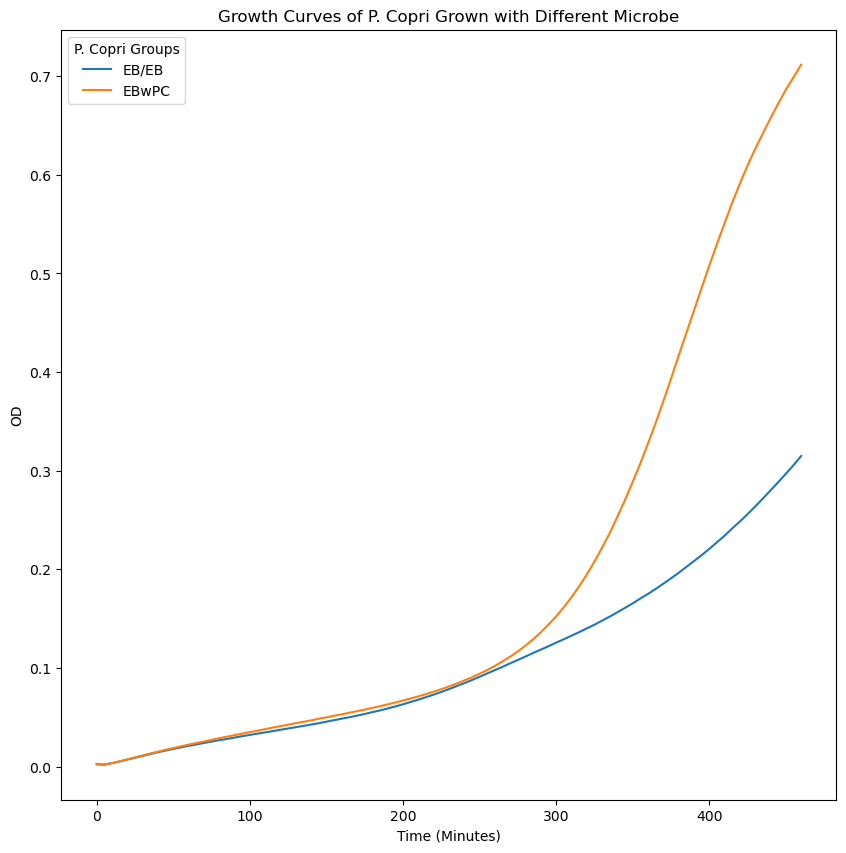

In [25]:
fig, ax = plt.subplots(figsize = (10,10))

sns.lineplot(data = cerillo_test_data[(cerillo_test_data['Group_together'] == 'EB/EB') | (cerillo_test_data['Group_together'] == 'EBwPC')], x='Time', y='OD', hue = 'Group_together')
ax.legend(title = 'P. Copri Groups')
plt.xlabel('Time (Minutes)')
plt.title('Growth Curves of P. Copri Grown with Different Microbe')

In [26]:
test_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwDO') | (cerillo_test_data['Group_together'] == 'DOwPC')]
microbe_data = test_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()

Text(0.5, 1.0, 'Growth Curves of P. Copri Grown with Different Microbe')

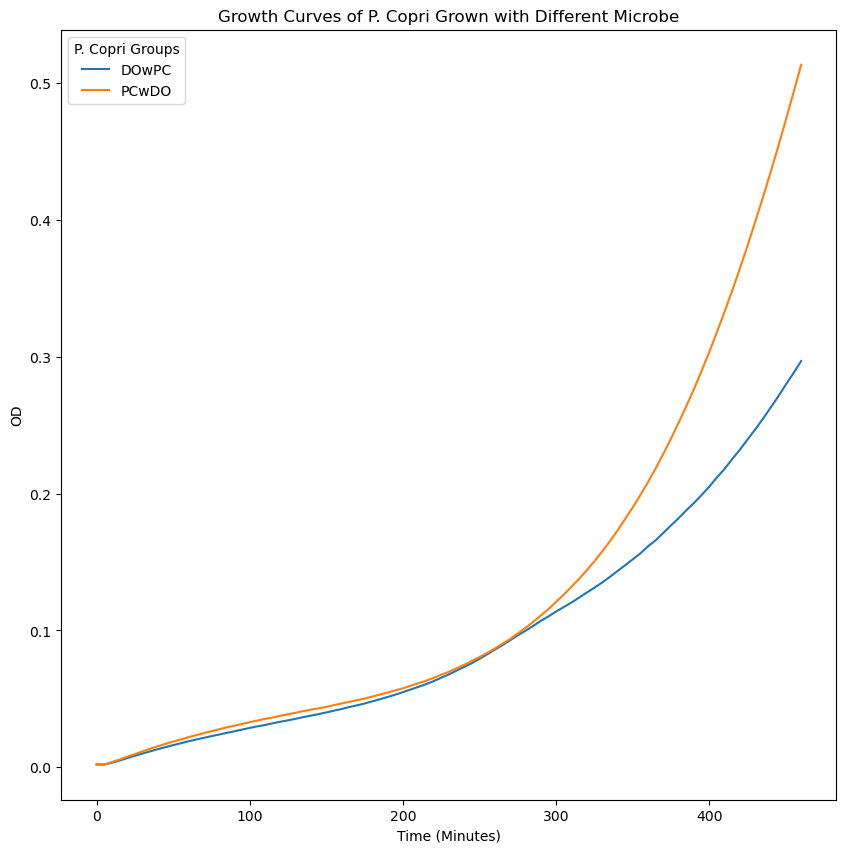

In [27]:
fig, ax = plt.subplots(figsize = (10,10))

sns.lineplot(data = test_df, x='Time', y='OD', hue = 'Group_together')
ax.legend(title = 'P. Copri Groups')
plt.xlabel('Time (Minutes)')
plt.title('Growth Curves of P. Copri Grown with Different Microbe')

In [28]:
microbe_data.head()

Group_together,Time,DOwPC,PCwDO
0,0,0.002200,0.001900
1,5,0.002067,0.002067
2,10,0.003367,0.003833
3,15,0.004933,0.005700
4,20,0.006767,0.007833


In [29]:
'''
# monoculture growth rate of EB
r_1 = 0.9659
# monoculture growth rate of P. copri
r_2 = 1.65
# co culture growth rate of EB
gamma_1 = 2
# co culture growth rate of P. copri
gamma_2 = 1
# intraspecies competition of EB
a_1 = -2.164
# intraspecies competition of P. copri
a_2 = -1.168
# initial concentration of EB
x0 = .002
# initial concentration of P. copri
y0 = .002

# Sample parameter values 
# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9
# initial concentration of EB
x0 = .002
# initial concentration of P. copri
y0 = .002

init_cond = np.array([x0, y0])
params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])
#params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2, x0, y0])

'''

'\n# monoculture growth rate of EB\nr_1 = 0.9659\n# monoculture growth rate of P. copri\nr_2 = 1.65\n# co culture growth rate of EB\ngamma_1 = 2\n# co culture growth rate of P. copri\ngamma_2 = 1\n# intraspecies competition of EB\na_1 = -2.164\n# intraspecies competition of P. copri\na_2 = -1.168\n# initial concentration of EB\nx0 = .002\n# initial concentration of P. copri\ny0 = .002\n\n# Sample parameter values \n# monoculture growth rate of EB\nr_1 = 0.04198\n# monoculture growth rate of P. copri\nr_2 = .115\n# co culture growth rate of EB\ngamma_1 = 5\n# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB\ngamma_2 = 0\n# intraspecies competition of EB\na_1 = -10\n# intraspecies competition of P. copri\na_2 = -2.9\n# initial concentration of EB\nx0 = .002\n# initial concentration of P. copri\ny0 = .002\n\ninit_cond = np.array([x0, y0])\nparams = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])\n#params = np.array([r_1, r_2,

In [30]:
'''
# calculate least squares using the Scipy solver

### set bounds such that self interaction param has to be <0 and that co culture growth rate can be anything 

results = least_squares(ode_model_resid, x0=params, bounds=([0, 0, 0, -10, -10, -10], [10, 10, 10, 10, 0, 0]), xtol = 1e-10)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["r_1", "r_2","gamma_1", "gamma_2","a_1","a_2"]
#parameter_names = ["r_1", "r_2", "gamma_1", "gamma_2", "a_1", "a_2", "x_0", "y_0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(4)

'''

'\n# calculate least squares using the Scipy solver\n\n### set bounds such that self interaction param has to be <0 and that co culture growth rate can be anything \n\nresults = least_squares(ode_model_resid, x0=params, bounds=([0, 0, 0, -10, -10, -10], [10, 10, 10, 10, 0, 0]), xtol = 1e-10)\n\n# put the results in a dataframe for presentation and convenience\ndf = pd.DataFrame()\nparameter_names = ["r_1", "r_2","gamma_1", "gamma_2","a_1","a_2"]\n#parameter_names = ["r_1", "r_2", "gamma_1", "gamma_2", "a_1", "a_2", "x_0", "y_0"]\ndf["Parameter"] = parameter_names\ndf["Least Squares Solution"] = results.x\ndf.round(4)\n\n'

In [34]:
#x_y, params = ls_glv_fit(init_abun=init_abun,params=params, total_sim_time=460, time_steps=460, microbe_data=microbe_data)
glv_out = odeint(multi_spec_gLV, y0 = init_abun, t=time, args = (params,))

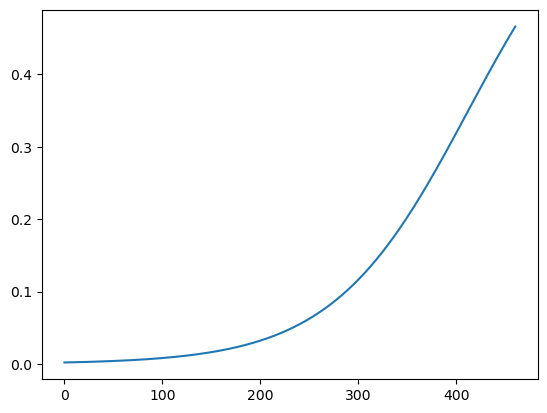

In [35]:
plt.plot(range(0,461), glv_out[:,1])

In [36]:
model_names = ['eb', 'p_copri', 'do']
models = [eb_model, p_copri_model, do_model]


In [37]:
#init_abun = [.0023, .002633]
init_abun = [0.0, .002, .002]

### so far must manually set initial values of parameters
### also might want to manually specify bounds too, could be something good 

# monoculture growth rate of EB
r_1 = 0.04198
# monoculture growth rate of P. copri
r_2 = .115
# co culture growth rate of EB
gamma_1 = 5
# co culture growth rate of P. copri # should be small b/c p. copri grows pretty much the same with or without EB
gamma_2 = 0
# intraspecies competition of EB
a_1 = -10
# intraspecies competition of P. copri
a_2 = -2.9


params = np.array([r_1, r_2, gamma_1, gamma_2, a_1, a_2])

params = np.array( [0.01506192,  0.01410974,  0.0151906,  0.04874128,  0.,          0.00151483,0.00170373,  0. ,        -0.03227239, -0.04587137, -0.02085214, -0.01264632])
'''
total_sim_time = 460
num_t_steps = 460

'''



'\ntotal_sim_time = 460\nnum_t_steps = 460\n\n'

In [38]:
def model_opt_out(model_abun_dict, delta_t, pfba):

    total_sys_uptake = {}
    total_sys_secretion = {}

    for key in model_abun_dict:

        if pfba == True:

            # optimize model i via pfba 
            temp_pfba = cobra.flux_analysis.pfba(model_abun_dict[key]['model'])
            print(temp_pfba.status)
            print(temp_pfba)
            print(model_abun_dict[key]['model'].reactions.get_by_id(id = 'biomassPan').upper_bound)

            ## seem to have some infeasible solutions, unclear why 
            # put fluxes in df for manipulation
            temp_pfba_df = temp_pfba.to_frame().filter(regex='EX_', axis = 0)
            
            # filter out fluxes that are secreted
            # signs are flipped here compared to standard fba optimization in cobrapy so must change them

            # secreted should have negative sign to align with normal FBA
            test_secrete = temp_pfba_df[temp_pfba_df['fluxes'] > 0]
            #print(test_secrete)

            # filter out fluxes that are taken up
            # uptake should have positive sign to align with normal FBA
            test_uptake = temp_pfba_df[temp_pfba_df['fluxes'] < 0]

            temp_uptake = np.abs(test_uptake['fluxes']) * delta_t * model_abun_dict[key]['abun']
            temp_secrete = -1.0*(test_secrete['fluxes']) * delta_t * model_abun_dict[key]['abun']   
            #print(temp_secrete)
            ## basically need to account for case when objective value is zero so need to add if statement to get around if this is the case
            if model_abun_dict[key]['model'].reactions.get_by_id(id = 'biomassPan').upper_bound < 1e-6:
                pfba_obj_val = 0
            else:
                pfba_obj_val = test_secrete.filter(regex='bio', axis=0)['fluxes'].iloc[0]

            print('Obj val', pfba_obj_val)
            model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + pfba_obj_val
        
        else:

            test_secrete = model_abun_dict[key]['model'].summary().secretion_flux.loc[model_abun_dict[key]['model'].summary().secretion_flux['reaction'].filter(regex='EX_')]
            test_uptake = model_abun_dict[key]['model'].summary().uptake_flux.loc[model_abun_dict[key]['model'].summary().uptake_flux['reaction'].filter(regex='EX_')]

            test_secrete = test_secrete[test_secrete['flux'] !=0 ]
            test_uptake = test_uptake[test_uptake['flux'] !=0 ]

            temp_uptake = test_uptake['flux'] * delta_t * model_abun_dict[key]['abun']
            temp_secrete = test_secrete['flux'] * delta_t * model_abun_dict[key]['abun']

            ### now that we've converted metabolite fluxes using abundance of previous time step, now update bacterial abundance for time t + 1

            #model_abun_dict[key]['abun'] += model_abun_dict[key]['model'].summary()._objective_value * model_abun_dict[key]['abun'] * delta_t

            #print(model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun'], 'add this amount')
            #print(model_abun_dict[key]['model'].summary()._objective_value, 'model obj')
            #print(model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun'], 'amount add')


            #model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + model_abun_dict[key]['model'].summary()._objective_value * delta_t * model_abun_dict[key]['abun']
            model_abun_dict[key]['abun'] = model_abun_dict[key]['abun'] + model_abun_dict[key]['model'].summary()._objective_value

            #print('Obj val', model_abun_dict[key]['model'].summary()._objective_value)

        ### this is wrong for some reason... 
        
        model_abun_dict[key]['fba_biomass'].append(model_abun_dict[key]['abun'])
        #print(model_abun_dict[model_names[i]]['abun'])

        # dict of uptake for model x in i to n 
        uptake_dict = dict(zip(temp_uptake.index, temp_uptake))
        # add uptake_dict at time t to model storage
        model_abun_dict[key]['flux_up'].append(uptake_dict.copy())
        # dict of sec for model x in i to n 
        secrete_dict = dict(zip(temp_secrete.index, temp_secrete))
        # add sec_dict at time t to model storage
        model_abun_dict[key]['flux_sec'].append(secrete_dict.copy())

        for key in uptake_dict:
            if key in total_sys_uptake.keys():
                #print(uptake_dict[key])
                #print(met_pool_dict[key])
                total_sys_uptake[key] += uptake_dict[key]
                #print(total_sys_uptake[key])
            else:
                total_sys_uptake[key] = np.abs(uptake_dict[key])
            #else:
                ### if there's a key in uptake dict that isn't found in met_pool something is wrong, kill sim ###
            #    RuntimeError()

        for key in secrete_dict:
            if key in total_sys_secretion.keys():
                total_sys_secretion[key] += np.abs(secrete_dict[key])
            else:
                if key == 'EX_biomass(e)':
                    #print('biomass')
                    continue
                else:
                    ### here add new metabolite to metabolite pool 
                    total_sys_secretion[key] = np.abs(secrete_dict[key])
                    #print(np.abs(secrete_dict[key]))
            

    return total_sys_uptake, total_sys_secretion

In [39]:
'''

glv_out, params_ls = ls_glv_fit(init_abun = init_abun, params = params, total_sim_time=total_sim_time, time_steps=num_t_steps, microbe_data=microbe_data)


print(glv_out)
print(params_ls)
'''

met_pool_list_of_dicts, abun, params_ls = static_dfba(list_model_names=model_names,list_models=models, initial_abundance=init_abun, total_sim_time=(200), num_t_steps=(200), microbe_data=microbe_data, glv_params_init=params, environ_cond= rcm_add, pfba=True, glv_out=glv_out)

Time step:  0
optimal
<Solution 0.000 at 0x178762060>
0
Obj val 0
optimal
<Solution 0.023 at 0x17530e990>
2.814288636e-05
Obj val 2.814288636e-05
optimal
<Solution 0.015 at 0x17530e330>
3.020152516e-05
Obj val 3.020152516e-05
Time step:  1
optimal
<Solution 0.000 at 0x1787623f0>
0
Obj val 0
optimal
<Solution 0.024 at 0x17875d3d0>
2.854060637061909e-05
Obj val 2.854060637061909e-05
optimal
<Solution 0.015 at 0x17875d820>
3.0658407975605505e-05
Obj val 3.0658407975605505e-05
Time step:  2
optimal
<Solution 0.000 at 0x178762060>
0
Obj val 0
optimal
<Solution 0.024 at 0x17530f5c0>
2.894391419152696e-05
Obj val 2.894391419152696e-05
optimal
<Solution 0.016 at 0x17530f140>
3.112212083246383e-05
Obj val 3.112212083246383e-05
Time step:  3
optimal
<Solution 0.000 at 0x1787622a0>
0
Obj val 0
optimal
<Solution 0.024 at 0x17875c680>
2.9352884400926624e-05
Obj val 2.9352884400926624e-05
optimal
<Solution 0.016 at 0x17875cad0>
3.15927594701189e-05
Obj val 3.15927594701189e-05
Time step:  4
optimal


In [ ]:
abun['do']['fba_biomass']

[0.002,
 0.00203020152516,
 0.002060859933135605,
 0.002091982053968069,
 0.002123574813438188,
 0.002155645250365858,
 0.0021882004700390077,
 0.002221247700343445,
 0.0022547942838302463,
 0.0022888476775706794,
 0.0023234154530079876,
 0.0023585052926661486,
 0.00239412498533354,
 0.0024302824304771563,
 0.002466985638223315,
 0.0025042427291958468,
 0.002542061935537181,
 0.002580451621191385,
 0.0026194202752992234,
 0.002658976506166776,
 0.0026991290410778132,
 0.002739886726102303,
 0.002781258574605875,
 0.0028232536419722995,
 0.002865881189330751,
 0.002909150599993503,
 0.0029530713811022637,
 0.002997653166072789,
 0.0030429057344500032,
 0.003088839009245846,
 0.003135463053492704,
 0.0031827880727662555,
 0.0032308244176994117,
 0.003279582586487121,
 0.003329073227381801,
 0.0033793071411791563,
 0.0034302952829048917,
 0.003482048759323234,
 0.003534578834023462,
 0.003587896930384791,
 0.003642014633771561,
 0.0036969436937177133,
 0.003752696026100299,
 0.00380928371

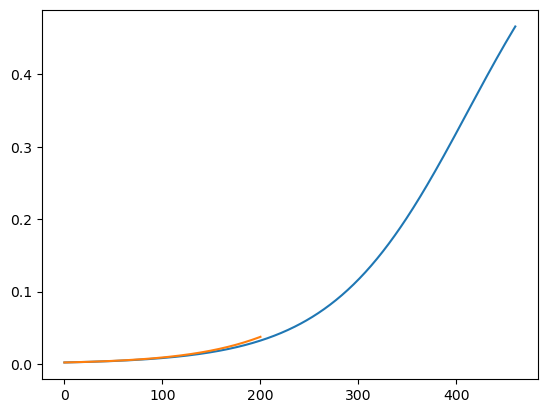

In [ ]:
plt.plot(range(0,461), glv_out[:,1])
plt.plot(range(0,201), abun['do']['fba_biomass'])

In [33]:
time = np.arange(0, 461, 1)


In [ ]:


#params = results.x
#x_y = odeint(generalized_gLV_test, y0 = params[-2:], t=time, args = (params,))
#x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))
x = glv_out[:,0]; y = glv_out[:,1]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time, x, label = 'EB(LS model)')
ax.plot(time, y, label = 'PC (LS model)')
ax.plot(microbe_data['Time'], microbe_data['DOwPC'], marker = 'o', lw =0, label = 'EB (data)')
ax.plot(microbe_data['Time'], microbe_data['PCwDO'], marker = '+', lw =0, label = 'PC (data)')
ax.plot(time[0:41], abun['eb']['fba_biomass'], label = 'EB (FBA)')


#ax.plot(time, x_naive, color = 'red' , label = 'naive_F_prau')
#ax.plot(time, y_naive, color = 'black', label = 'naive_P_copri')



plt.legend()
plt.show()



In [ ]:

testing_abun = [.002]
for i in range(0, 101):

    #print(x[i]+ x[i] * generalized_gLV([x[i], y[i]], time[i], params=params)[0])
    #print(abun['eb']['glv_out'][i]+ abun['eb']['glv_out'][i] * generalized_gLV([x[i], y[i]], time[i], params=params)[0])
    print(x[i])
    print(generalized_gLV([x[i], y[i]], time[i], params=params)[0])
    #print(abun['eb']['glv_out'][i] * generalized_gLV([x[i], y[i]], time[i], params=params)[0])


NameError: name 'x' is not defined

In [ ]:

### implementing bayesian inference for gLV dynamics 
### based on tutorial found here:
### https://www.pymc.io/projects/examples/en/latest/ode_models/ODE_Lotka_Volterra_multiple_ways.html

# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(params_ls):
    return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))

def bayesian_glv_setup(params_init, microbe_data):

    #params = results.x  # least squares solution used to inform the priors
    with pm.Model() as model:
        # Priors
        r_1 = pm.TruncatedNormal("r_1", mu=params_init[0], sigma=0.1, lower=0, initval=params_init[0])
        r_2 = pm.TruncatedNormal("r_2", mu=params_init[1], sigma=0.01, lower=0, initval=params_init[1])
        ### Should I make gamma normally distributed? or at least gamma_2 for PC due to 
        gamma_1 = pm.TruncatedNormal("gamma_1", mu=params_init[2], sigma=0.1, lower=0, initval=params_init[2])
        gamma_2 = pm.TruncatedNormal("gamma_2", mu=params_init[3], sigma=0.01, lower=0, initval=params_init[3])
        a_1 = pm.TruncatedNormal("a_1", mu=params_init[4], sigma=1, upper=0, initval=params_init[4])
        a_2 = pm.TruncatedNormal("a_2", mu=params_init[5], sigma=1, upper=0, initval=params_init[5])
        sigma = pm.HalfNormal("sigma", 10)

        # Ode solution function
        ode_solution = pytensor_forward_model_matrix(
            pm.math.stack([r_1, r_2, gamma_1, gamma_2, a_1, a_2])
        )

        # Likelihood
        pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=microbe_data[["EBwPC", "PCwEB"]].values)

        return model


digraph {
	sigma [label="sigma
~
HalfNormal" shape=ellipse]
	a_2 [label="a_2
~
TruncatedNormal" shape=ellipse]
	gamma_2 [label="gamma_2
~
TruncatedNormal" shape=ellipse]
	gamma_1 [label="gamma_1
~
TruncatedNormal" shape=ellipse]
	r_1 [label="r_1
~
TruncatedNormal" shape=ellipse]
	a_1 [label="a_1
~
TruncatedNormal" shape=ellipse]
	r_2 [label="r_2
~
TruncatedNormal" shape=ellipse]
	subgraph "cluster93 x 2" {
		Y_obs [label="Y_obs
~
Normal" shape=ellipse style=filled]
		label="93 x 2" labeljust=r labelloc=b style=rounded
	}
	r_2 -> Y_obs
	a_2 -> Y_obs
	sigma -> Y_obs
	gamma_2 -> Y_obs
	gamma_1 -> Y_obs
	a_1 -> Y_obs
	r_1 -> Y_obs
}



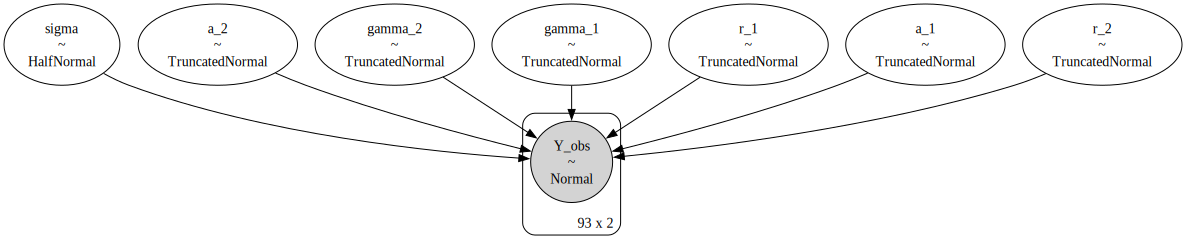

In [ ]:
model = bayesian_glv_setup(params_init=params_ls, microbe_data=microbe_data)
(pm.model_to_graphviz(model=model))

In [ ]:

def bayesian_glv_run(model, num_samples, chains):
    # Variable list to give to the sample step parameter
    vars_list = list(model.values_to_rvs.keys())[:-1]

    sampler = "DEMetropolisZ"
    tune = draws = num_samples
    with model:
        trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, chains=chains)
    trace = trace_DEMZ
    #az.summary(trace)

    return trace



In [ ]:
trace = bayesian_glv_run(model=model, num_samples=10000, chains =5)

Multiprocess sampling (5 chains in 4 jobs)
DEMetropolisZ: [r_1, r_2, gamma_1, gamma_2, a_1, a_2, sigma]


Output()

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_92291/3715622821.py:8: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_92291/3715622821.py:8: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_92291/3715622821.py:8: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_92291/3715622821.py:8: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))


/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_92291/3715622821.py:8: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func=generalized_gLV, y0=init_abun, t=microbe_data['Time'], args=(params_ls,))


Sampling 5 chains for 10_000 tune and 10_000 draw iterations (50_000 + 50_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'a_1'}>,
        <Axes: title={'center': 'a_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'a_2'}>,
        <Axes: title={'center': 'a_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma_1'}>,
        <Axes: title={'center': 'gamma_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'gamma_2'}>,
        <Axes: title={'center': 'gamma_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'r_1'}>,
        <Axes: title={'center': 'r_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'r_2'}>,
        <Axes: title={'center': 'r_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

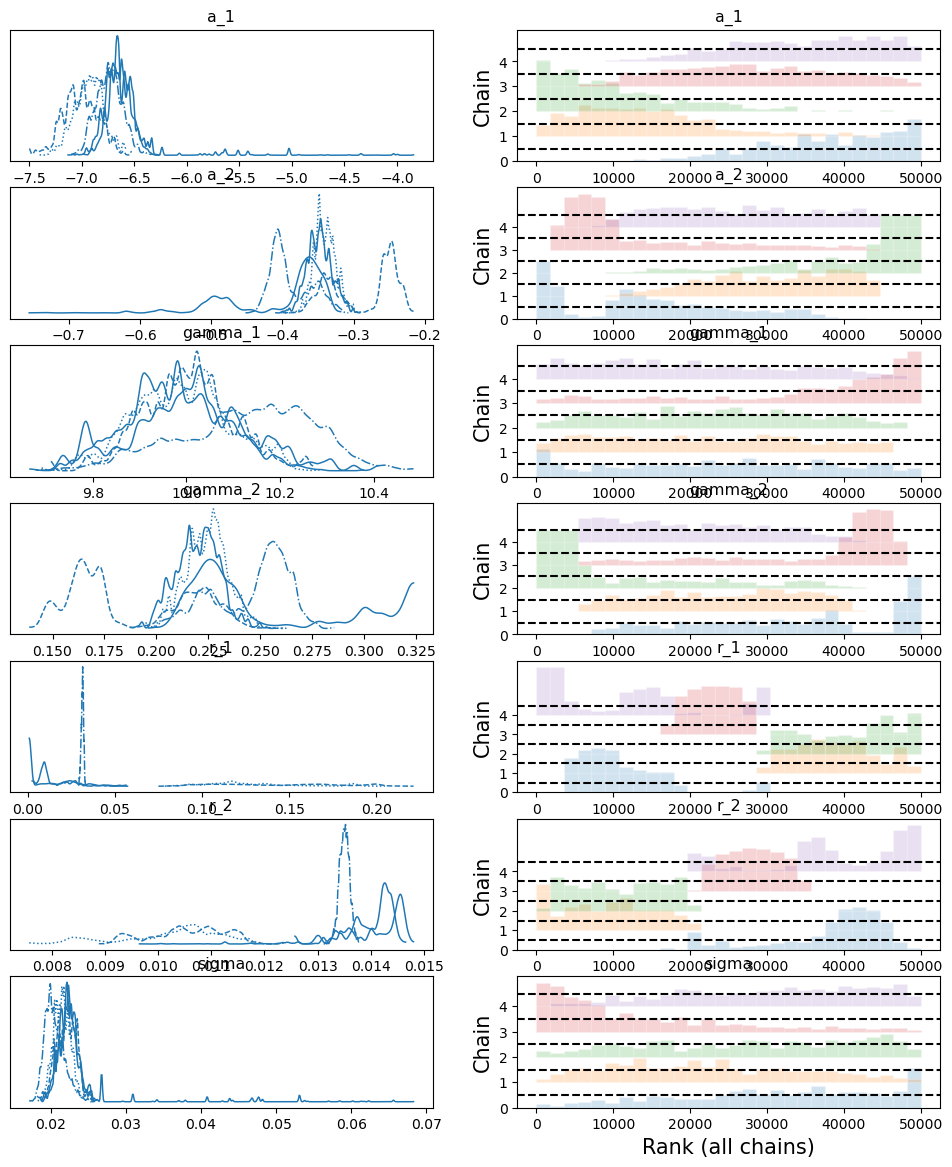

In [ ]:
az.plot_trace(trace, kind="rank_bars")
#plt.suptitle(f"Trace Plot {sampler}");

In [ ]:
### 

#az.summary(trace)[['mean','sd']]

#trace_df = az.extract(trace, num_samples=1000).to_dataframe()
#trace_df

az.summary(trace)[['mean', 'sd']].loc['a_1']

### should probably shove this crap into a dict for easier accessibilty and so stuff doesn't get lost 
## guess dict of dicts also makes most sense here 


test_dict = {'a_1' : {'upper_lim' : 0, 'lower_lim': -np.inf}, 'a_2' : {'upper_lim' : 0, 'lower_lim': -np.inf}, 'r_1' : {'upper_lim' : np.inf, 'lower_lim': 0}, 'r_2' : {'upper_lim' : np.inf, 'lower_lim': 0}, 'gamma_1' : {'upper_lim' : np.inf, 'lower_lim': 0}, 'gamma_2' : {'upper_lim' : np.inf, 'lower_lim': 0}}
#params_names = ['a_1', 'a_2', 'r_1', 'r_2', 'gamma_1', 'gamma_2']
#upper_lim = [0, 0, np.inf, np.inf, np.inf, np.inf]
#lower_lim = [-np.inf, -np.inf, 0, 0, 0, 0]

In [ ]:
# gamma_1, r_1 lower
# a_1 upper 


def posterior_param_samps(num_samples, param_dict, glv_trace):

    for key in param_dict:

        #print(params_names[i])
        #print(pm.summary(trace)[['mean','sd']].loc[params_names[i]])
        mu = pm.summary(glv_trace)[['mean','sd']].loc[key].iloc[0]
        sd = pm.summary(glv_trace)[['mean','sd']].loc[key].iloc[1] 
        
        lower = param_dict[key]['lower_lim']
        upper = param_dict[key]['upper_lim']

        N = num_samples

        samples = truncnorm.rvs((lower-mu)/sd,(upper-mu)/sd,loc = mu, scale=sd, size = N)

        param_dict[key]['samples'] = samples
        #samples

        plt.hist(samples, bins=20, density=True)
        plt.show()
        plt.close()

    return param_dict



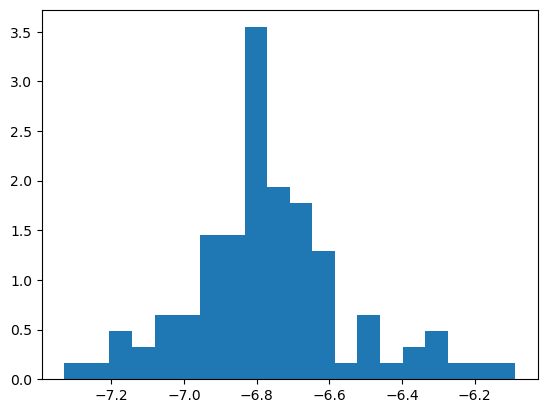

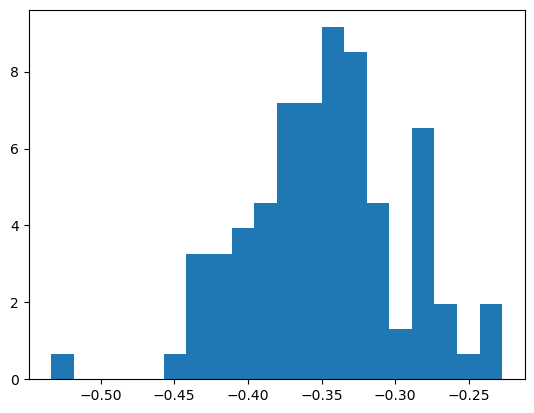

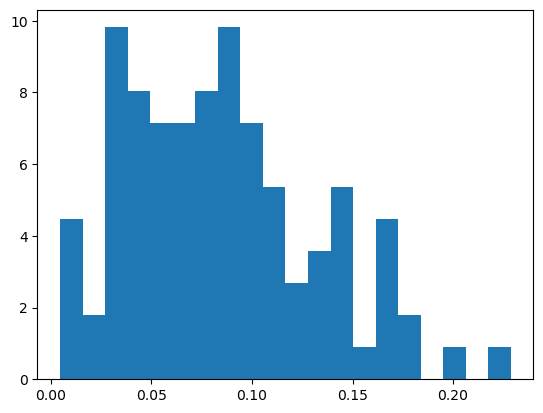

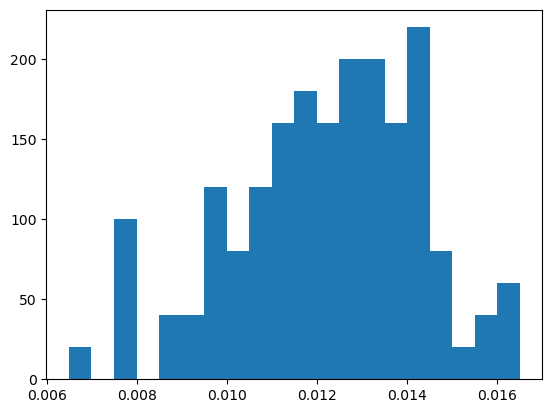

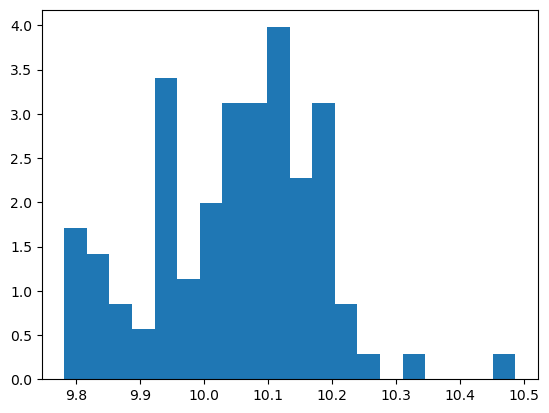

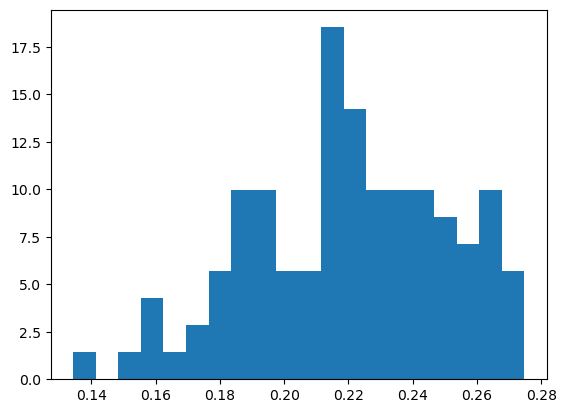

In [ ]:
param_dict = posterior_param_samps(num_samples=100, param_dict=test_dict, glv_trace=trace)

In [ ]:

param_dict['a_1']['samples'][0]
#met_pool_list_of_dicts, abun = static_dfba(list_model_names=model_names,list_models=models, initial_abundance=init_abun, total_sim_time=(460), num_t_steps=(460), glv_out= x_y, glv_params = params, environ_cond= rcm_add, pfba=True)

-7.329214773808091

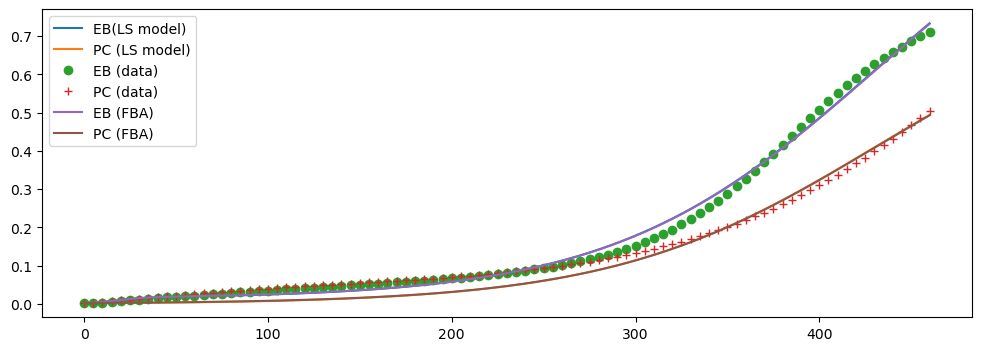

In [ ]:
time = np.arange(0, 461, 1)
#params = results.x
#x_y = odeint(generalized_gLV, y0 = init_abun, t=time, args = (params,))
x = x_y[:,0]; y = x_y[:,1]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time, x, label = 'EB(LS model)')
ax.plot(time, y, label = 'PC (LS model)')
ax.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)')
ax.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)')
ax.plot(time, abun['eb']['fba_biomass'], label = 'EB (FBA)')
ax.plot(time, abun['p_copri']['fba_biomass'], label = 'PC (FBA)')


#ax.plot(time, x_naive, color = 'red' , label = 'naive_F_prau')
#ax.plot(time, y_naive, color = 'black', label = 'naive_P_copri')



plt.legend()
plt.show()



In [ ]:
test = pd.DataFrame(met_pool_list_of_dicts)

In [ ]:
test = np.transpose(test)
test = test.fillna(0)

In [ ]:
test = test.unstack()
test = pd.DataFrame(test).reset_index()
test.columns = ['time', 'reaction', 'fluxValue']

In [ ]:
test.head()

,time,reaction,fluxValue
0,0,EX_ribflv(e),0.01
1,0,EX_thymd(e),0.01
2,0,EX_thm(e),0.01
3,0,EX_spmd(e),0.01
4,0,EX_sheme(e),0.01


In [ ]:
test_2 = pd.DataFrame(met_pool_list_of_dicts)
test_2 = np.transpose(test_2)
test_2 = test_2.fillna(0)
test_2

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
EX_ribflv(e),0.010000,9.999993e-03,9.999985e-03,9.999976e-03,9.999964e-03,9.999950e-03,9.999934e-03,9.999914e-03,9.999891e-03,9.999864e-03,...,0.006181,0.006136,0.006091,0.006045,0.005999,0.005954,0.005908,0.005862,0.005815,0.005769
EX_thymd(e),0.010000,9.999994e-03,9.999986e-03,9.999977e-03,9.999966e-03,9.999953e-03,9.999938e-03,9.999920e-03,9.999899e-03,9.999874e-03,...,0.005330,0.005275,0.005219,0.005163,0.005107,0.005051,0.004995,0.004938,0.004881,0.004824
EX_thm(e),0.010000,9.999997e-03,9.999993e-03,9.999988e-03,9.999982e-03,9.999975e-03,9.999967e-03,9.999957e-03,9.999946e-03,9.999932e-03,...,0.008090,0.008068,0.008045,0.008023,0.008000,0.007977,0.007954,0.007931,0.007908,0.007885
EX_spmd(e),0.010000,9.999997e-03,9.999993e-03,9.999988e-03,9.999982e-03,9.999975e-03,9.999967e-03,9.999957e-03,9.999946e-03,9.999932e-03,...,0.008090,0.008068,0.008045,0.008023,0.008000,0.007977,0.007954,0.007931,0.007908,0.007885
EX_sheme(e),0.010000,9.999997e-03,9.999993e-03,9.999988e-03,9.999982e-03,9.999975e-03,9.999967e-03,9.999957e-03,9.999946e-03,9.999932e-03,...,0.008090,0.008068,0.008045,0.008023,0.008000,0.007977,0.007954,0.007931,0.007908,0.007885
EX_q8(e),0.010000,9.999997e-03,9.999993e-03,9.999988e-03,9.999982e-03,9.999975e-03,9.999967e-03,9.999957e-03,9.999946e-03,9.999932e-03,...,0.008090,0.008068,0.008045,0.008023,0.008000,0.007977,0.007954,0.007931,0.007908,0.007885
EX_pheme(e),0.010000,9.999997e-03,9.999993e-03,9.999988e-03,9.999982e-03,9.999975e-03,9.999967e-03,9.999957e-03,9.999946e-03,9.999932e-03,...,0.008090,0.008068,0.008045,0.008023,0.008000,0.007977,0.007954,0.007931,0.007908,0.007885
EX_fol(e),0.010000,9.999990e-03,9.999978e-03,9.999964e-03,9.999946e-03,9.999925e-03,9.999901e-03,9.999871e-03,9.999837e-03,9.999797e-03,...,0.004271,0.004204,0.004136,0.004068,0.003999,0.003930,0.003862,0.003793,0.003723,0.003654
EX_2dmmq8(e),0.010000,9.999993e-03,9.999985e-03,9.999976e-03,9.999964e-03,9.999950e-03,9.999934e-03,9.999914e-03,9.999891e-03,9.999864e-03,...,0.006181,0.006136,0.006091,0.006045,0.005999,0.005954,0.005908,0.005862,0.005815,0.005769
EX_26dap_M(e),0.010000,9.999999e-03,9.999998e-03,9.999997e-03,9.999996e-03,9.999994e-03,9.999992e-03,9.999990e-03,9.999988e-03,9.999985e-03,...,0.009566,0.009560,0.009555,0.009550,0.009545,0.009540,0.009535,0.009529,0.009524,0.009519


In [ ]:
diff_df = pd.DataFrame(test_2.iloc[:,0] - test_2.iloc[:,459])

In [ ]:
diff_df.columns = ['diff']

In [ ]:
test_2_filt = test_2[test_2.index.isin(diff_df[diff_df['diff'] !=0].index)]

In [ ]:
test_2_filt = test_2_filt.unstack()
test_2_filt = pd.DataFrame(test_2_filt).reset_index()
test_2_filt.columns = ['time', 'reaction', 'fluxValue']

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_81422/789051980.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-10, 100000)


(2.4871139260861735e-09, 100000)

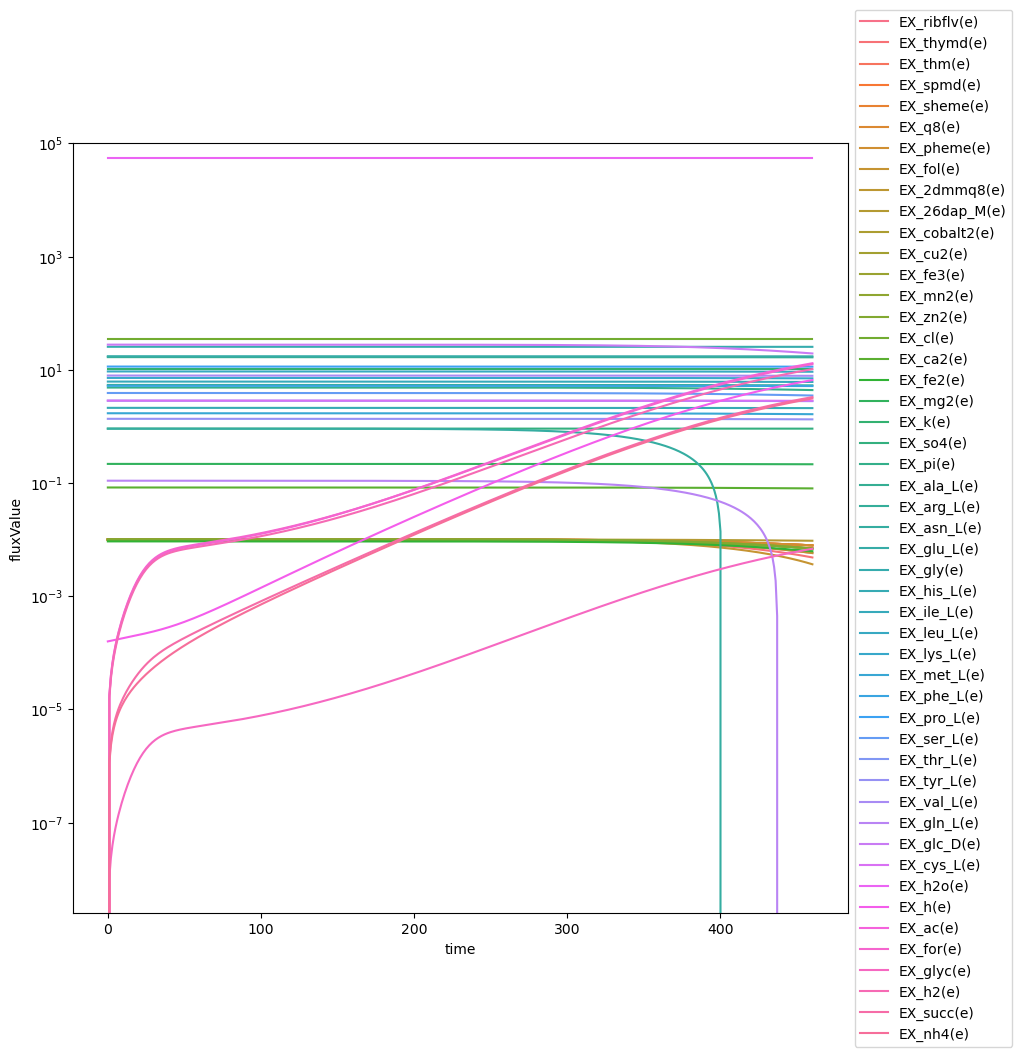

In [ ]:
axs, fig = plt.subplots(figsize= (10,10))
sns.lineplot(data = test_2_filt, x='time', y='fluxValue', hue = 'reaction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(-10, 100000)

In [ ]:
## aim 2 targeted metabolmic data to link consumpption and growth 
### specific metabolites that are telling 
abun['eb']['flux_up']

[{'EX_26dap_M(e)': 8.666100265072045e-10,
  'EX_2dmmq8(e)': 7.619316347333209e-09,
  'EX_ala_L(e)': 2.3237489782250548e-07,
  'EX_arg_L(e)': 9.279795090332394e-08,
  'EX_asn_L(e)': 2.2576234807596101e-07,
  'EX_ca2(e)': 3.8096581736666036e-09,
  'EX_cl(e)': 3.8096581736666036e-09,
  'EX_cobalt2(e)': 3.8096581736666036e-09,
  'EX_cu2(e)': 3.8096581736666036e-09,
  'EX_cys_L(e)': 3.8756867466955865e-08,
  'EX_fe2(e)': 3.8096581736666036e-09,
  'EX_fe3(e)': 3.8096581736666036e-09,
  'EX_fol(e)': 1.142897452099981e-08,
  'EX_glc_D(e)': 1.0762318427571972e-05,
  'EX_gln_L(e)': 2.5896362198166443e-07,
  'EX_gly(e)': 1.0856304643009359e-07,
  'EX_h(e)': 3.645247e-07,
  'EX_his_L(e)': 3.9320612619573883e-08,
  'EX_ile_L(e)': 1.696540391386417e-07,
  'EX_k(e)': 3.8096581736666036e-09,
  'EX_leu_L(e)': 2.0661487759822309e-07,
  'EX_lys_L(e)': 1.5531901089661818e-07,
  'EX_met_L(e)': 5.826967589614473e-08,
  'EX_mg2(e)': 3.8096581736666036e-09,
  'EX_mn2(e)': 3.8096581736666036e-09,
  'EX_phe_L(e

In [ ]:
abun['eb']['flux_sec']

[{'EX_ac(e)': -1.930827663421499e-05,
  'EX_biomass(e)': -4.798239446914371e-07,
  'EX_for(e)': -2.0241403982421244e-05,
  'EX_glyc(e)': -1.236088858637952e-08,
  'EX_h2(e)': -1.8295767788387742e-05,
  'EX_h2o(e)': -2.5393472613696512e-05,
  'EX_succ(e)': -1.1873550598716668e-07},
 {'EX_ac(e)': -2.3094130442754145e-05,
  'EX_biomass(e)': -5.734322189129359e-07,
  'EX_for(e)': -2.4209300479035596e-05,
  'EX_glyc(e)': -1.4772359421081817e-08,
  'EX_h2(e)': -2.18840924682944e-05,
  'EX_h2o(e)': -3.0328429110841497e-05,
  'EX_succ(e)': -1.4189947253620244e-07},
 {'EX_ac(e)': -2.7551218963030932e-05,
  'EX_biomass(e)': -6.836041013303744e-07,
  'EX_for(e)': -2.888064340996541e-05,
  'EX_glyc(e)': -1.7610530335602177e-08,
  'EX_h2(e)': -2.61086998738973e-05,
  'EX_h2o(e)': -3.613526325737078e-05,
  'EX_succ(e)': -1.6916220994046556e-07},
 {'EX_ac(e)': -3.276695147486966e-05,
  'EX_biomass(e)': -8.124937909336292e-07,
  'EX_for(e)': -3.434703138742071e-05,
  'EX_glyc(e)': -2.09308962963785e-0